In [1]:
import json
from netCDF4 import Dataset
import matplotlib.pyplot as plt
import numpy as np
import magneticfielddb as mag
import simplesimdb as simplesim
# maybe do this notebook with pyfeltor directly?

In [2]:
# A generic input file for geometry_diag that works for all
inputfile = {
    "grid": {
        "type": "Cartesian2d",
        "n": 3,
        "Nx": 80,
        "Ny": 80,
        "Nz": 20,
        "Npsi": 32,
        "Neta": 640,
        "fx_0": 0.0625,
        "scaleR": [1.2, 1.2],
        "scaleZ": [2.4, 2.4],
    },
    "boundary": {
        "wall": {"type": "heaviside", "boundary": 1.1, "alpha": 0.2},
        #         "sheath":
        #         {
        #             "boundary" : 3/32,
        #             "alpha" : 2/32,
        #             "max_angle" : 1e-3
        #         }
    },
    "diagnostics": ["q-profile"],  # "fsa", "sheath"
    "magnetic_field": {"input": "params"},
    "width-factor": 0.03,
}

In [3]:
# Display sorted contents of the data base
for f in sorted(mag.files()):
    print(f)
    # print(mag.select(f))

AUG/Iconst_Te_70eV_B0_2T.json
AUG/falchetto_Iconst_Te_150eV_B0_2T.json
COMPASS/Iconst.json
COMPASS/Iconst_woX.json
COMPASS/Iconst_woX_circ.json
COMPASS/compass_-1X.json
COMPASS/compass_-2X.json
COMPASS/compass_1X.json
COMPASS/compass_2X.json
COMPASS/woX_Taylor.json
COMPASS/woX_circ_Taylor.json
TJ-K/Iconst.json
TJ-K/Iconst_elong.json
TJ-K/Iconst_elong_d_e_AUG.json
TJ-K/Taylor.json
TJ-K/Taylor_circ.json
TJ-K/Taylor_elong.json
TJ-K/rfp_elong.json
TJ-K/woX_rfp_elong.json
circular.json
enrx_tcv.json
enrx_torpex.json
guenter.json
toroidal.json


 Since geometry_diag is fairly quick our idea is to store the input and output in temporary files
 that are overwritten in each simulation and removed at the end of the notebook

In [4]:
# Define a plotting routine
def plot(f):
    ncin = Dataset(f, "r", format="NETCDF4")
    pp = json.loads(ncin.inputfile)

    p = pp["magnetic_field"]["params"]
    equi = p["equilibrium"]
    desc = p["description"]

    x = ncin["R"][:]
    y = ncin["Z"][:]
    xc = np.kron(np.ones(np.shape(y)), x).reshape((np.size(y), np.size(x)))
    yc = np.kron(y, np.ones(np.shape(x))).reshape((np.size(y), np.size(x)))

    frows = 1
    fcols = 2
    fig, ax = plt.subplots(
        frows,
        fcols,
        figsize=(fcols * 5, frows * 6),
        dpi=80,
        facecolor="w",
        edgecolor="k",
    )
    # im = ax[0][0].pcolormesh(xc,yc,ncin["Psip"][:,:], shading='gouraud', cmap='seismic' )

    # https://matplotlib.org/stable/tutorials/colors/colormaps.html
    im = ax[0].contourf(xc, yc, ncin["Psip"][:, :], cmap="twilight_r")
    #     im = ax[0].pcolormesh(xc,yc,ncin["Rho_p"][:,:],cmap="gist_ncar", shading ="gouraud")
    fig.colorbar(im, ax=ax[0])
    if desc != "none":
        im = ax[0].contour(
            xc, yc, ncin["Psip"][:, :], levels=[0], linewidths=2, colors="k"
        )

    ax[0].set_title("Psi")
    ax[0].axis("scaled")
    ax[0].set_xlabel("R [m]")
    ax[0].set_ylabel("Z [m]")

    if desc != "none" and desc != "centeredX":
        rhot = ncin["rho_t"][:]
        idx = np.where(rhot < 1)
        im = ax[1].plot(rhot[idx], ncin["q-profile"][idx])
        ax[1].set_title("q-profile")
        ax[1].set_xlim([0, 1])
        ax[1].set_xlabel(r"$\rho_t$")

    print(equi, desc)
    if equi == "solovev" or equi == "polynomial":
        print(f"triangularity={p['triangularity']:.1f}", end=" ")
        print(f"elongation={p['elongation']:.1f}", end=" ")
        print(f"a/R_0={p['inverseaspectratio']:.1f}", end=" ")
    else:
        print(f"triangularity=0 elongation=1 a/R_0={1/p['R_0']:.1f}")
    # plt.savefig( "tcv")
    plt.show()
    ncin.close()

In [5]:
# Our first simulation
f = "guenter.json"
inputfile["magnetic_field"]["params"] = mag.select(f)
inputfile["magnetic_field"]["params"]["R_0"] = 3
inputfile["magnetic_field"]["params"]["I_0"] = 10
rep = simplesim.Repeater("./geometry_diag.sh", "temp.json", "temp.nc")
print(f)
rep.run(inputfile)

guenter.json


guenter square
triangularity=0 elongation=1 a/R_0=0.3


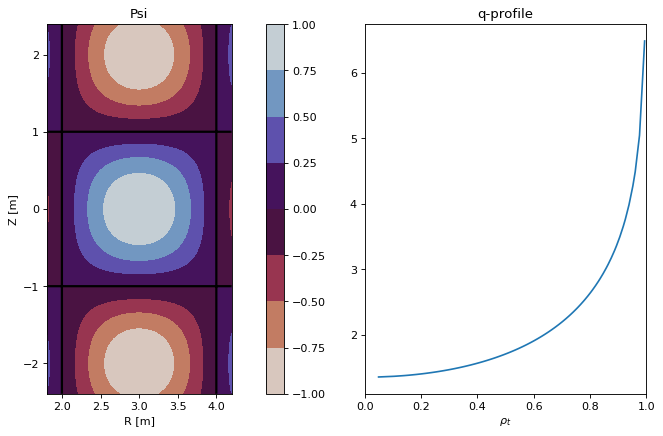

In [6]:
# plot our first simulation and fine-tune the plotting routine
plot("temp.nc")

A $q<0$ indicates left-handed magnetic field winding while $q>0$ indicates right-handed

AUG/Iconst_Te_70eV_B0_2T.json
solovev standardX
triangularity=0.3 elongation=1.7 a/R_0=0.3 

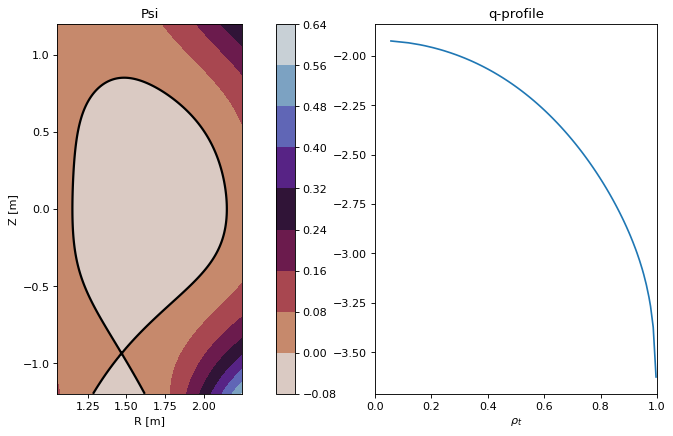

AUG/falchetto_Iconst_Te_150eV_B0_2T.json
solovev standardO
triangularity=0.3 elongation=1.7 a/R_0=0.3 

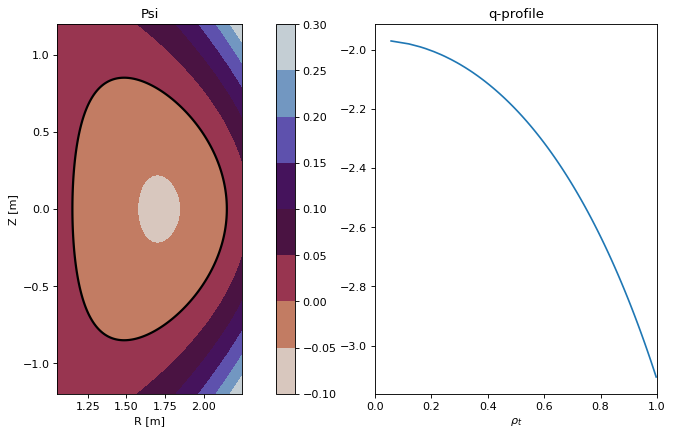

COMPASS/Iconst.json
Mathematica; geometry_params_Xpoint.json in Feltor
solovev standardX
triangularity=0.5 elongation=1.8 a/R_0=0.4 

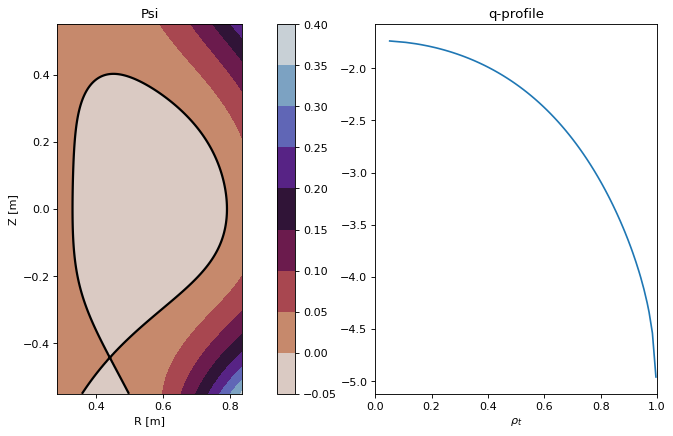

COMPASS/Iconst_woX.json
solovev standardO
triangularity=0.5 elongation=1.8 a/R_0=0.4 

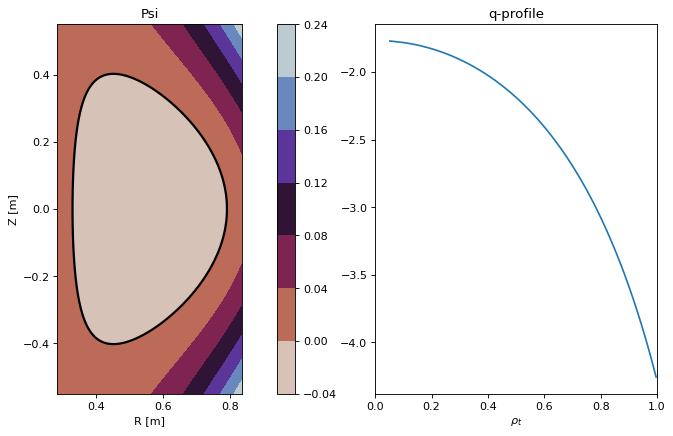

COMPASS/Iconst_woX_circ.json
solovev standardO
triangularity=0.0 elongation=1.0 a/R_0=0.4 

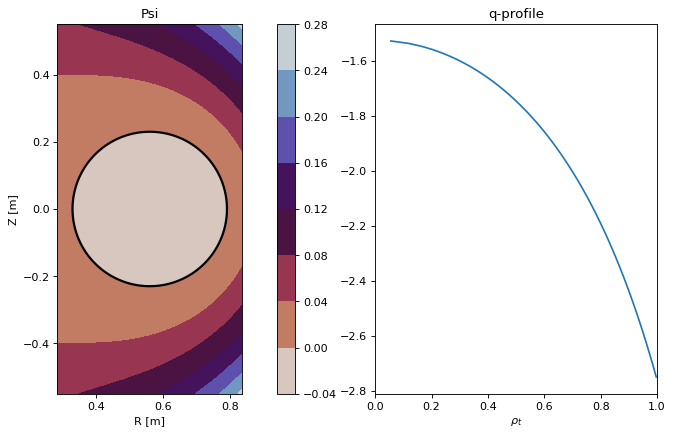

COMPASS/compass_-1X.json
Attention: Ipol can become NaN in corner regions outside LCFS
solovev standardX
triangularity=-0.3 elongation=1.4 a/R_0=0.3 

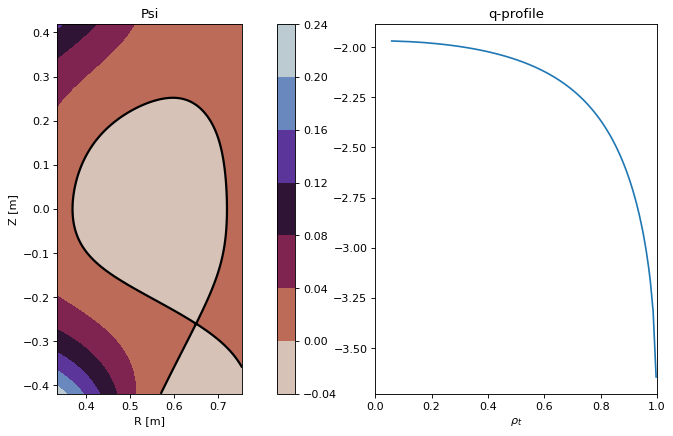

COMPASS/compass_-2X.json
solovev doubleX
triangularity=-0.3 elongation=1.4 a/R_0=0.3 

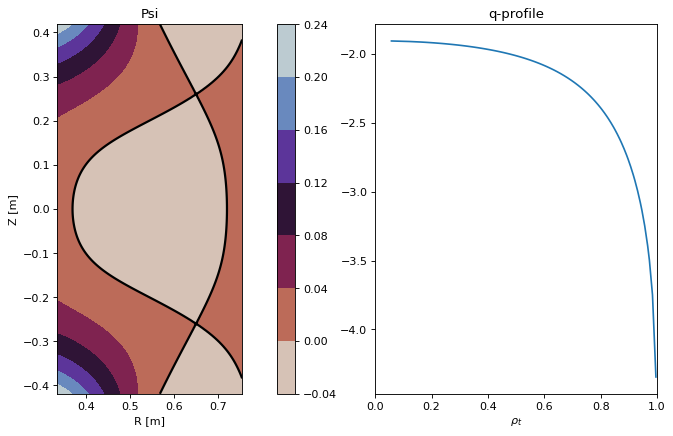

COMPASS/compass_1X.json
Mathematica; eye fit of Fig. 3 in R Panek et al 2015 Plasma Phys. Control. Fusion 58 014015
solovev standardX
triangularity=0.3 elongation=1.4 a/R_0=0.3 

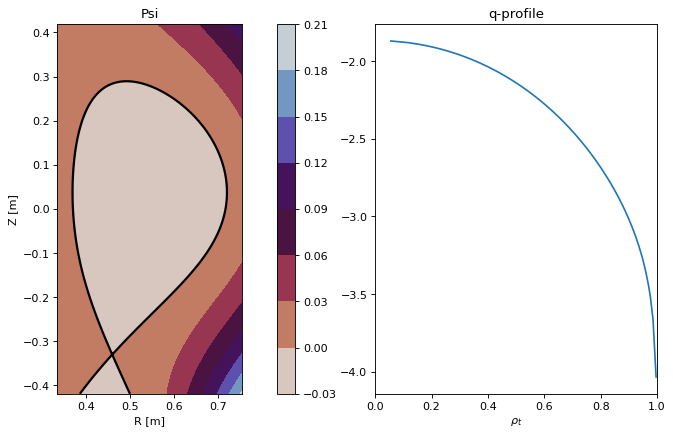

COMPASS/compass_2X.json
solovev doubleX
triangularity=0.3 elongation=1.4 a/R_0=0.3 

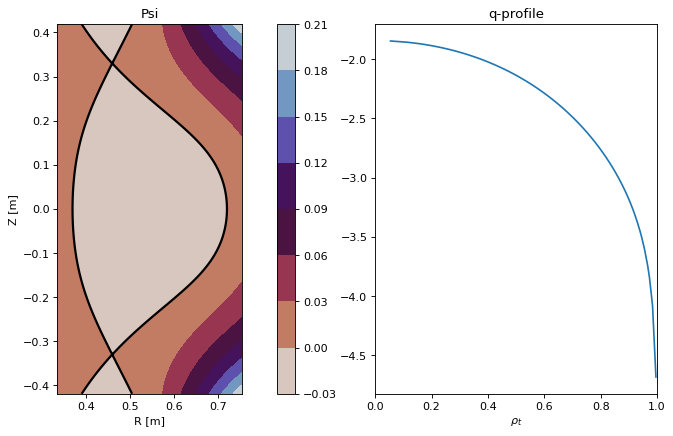

COMPASS/woX_Taylor.json
solovev standardO
triangularity=0.5 elongation=1.8 a/R_0=0.4 

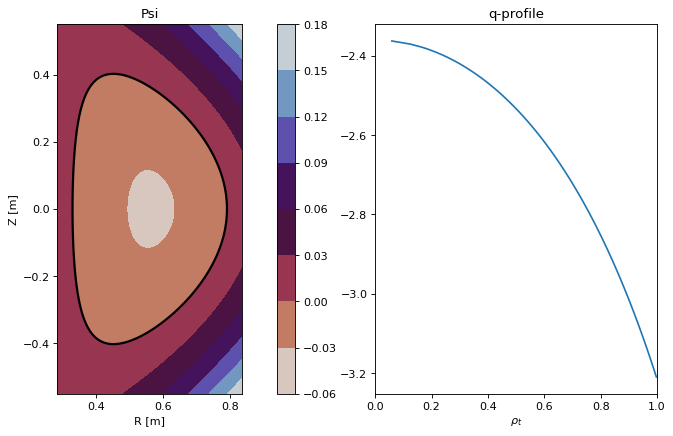

COMPASS/woX_circ_Taylor.json
Mathematica; used in Wiesenberger 2014, PhD thesis; geometry_params.json in Feltor
solovev standardO
triangularity=0.0 elongation=1.0 a/R_0=0.4 

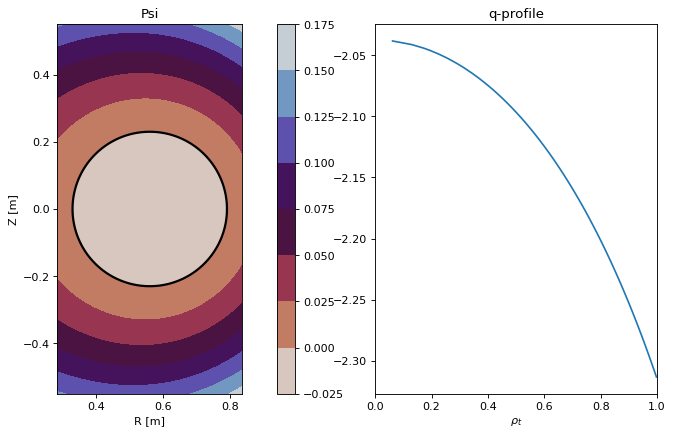

TJ-K/Iconst.json
solovev standardX
triangularity=0.0 elongation=1.0 a/R_0=0.2 

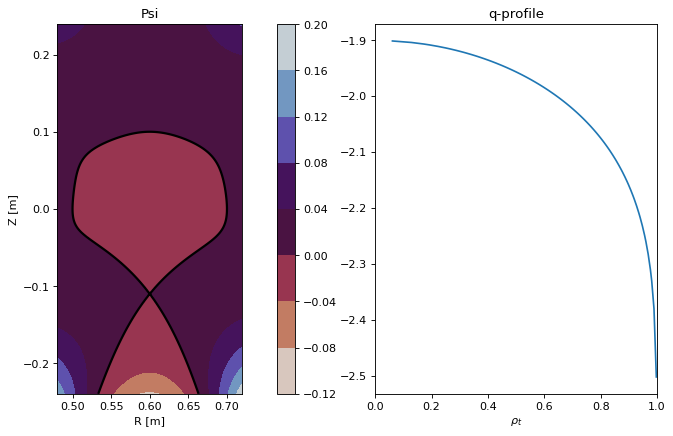

TJ-K/Iconst_elong.json
Mathematica; used in Wiesenberger 2014, PhD thesis
solovev standardX
triangularity=0.5 elongation=1.8 a/R_0=0.2 

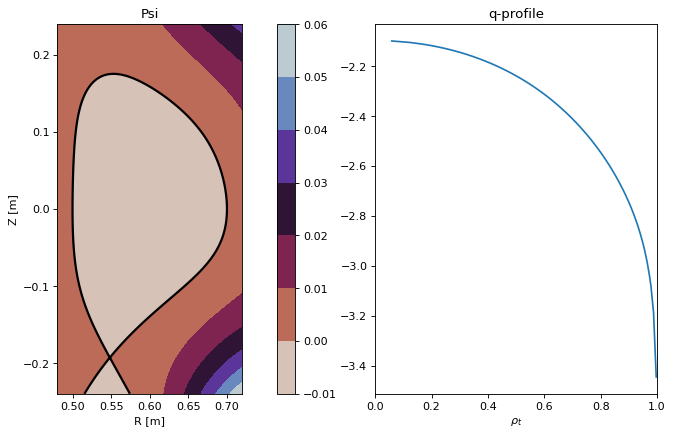

TJ-K/Iconst_elong_d_e_AUG.json
solovev standardX
triangularity=0.3 elongation=1.7 a/R_0=0.2 

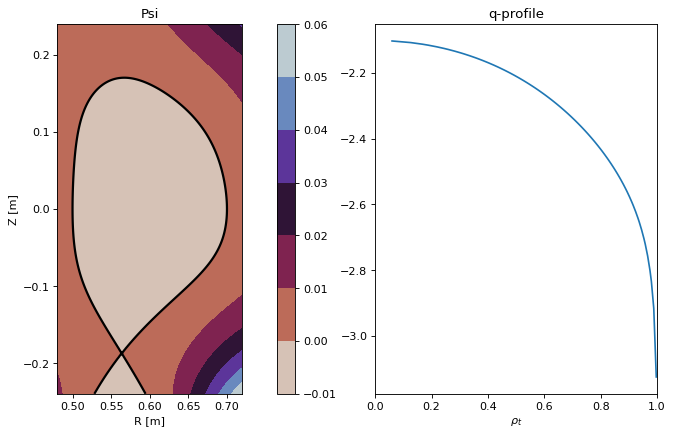

TJ-K/Taylor.json
solovev standardX
triangularity=0.0 elongation=1.0 a/R_0=0.2 

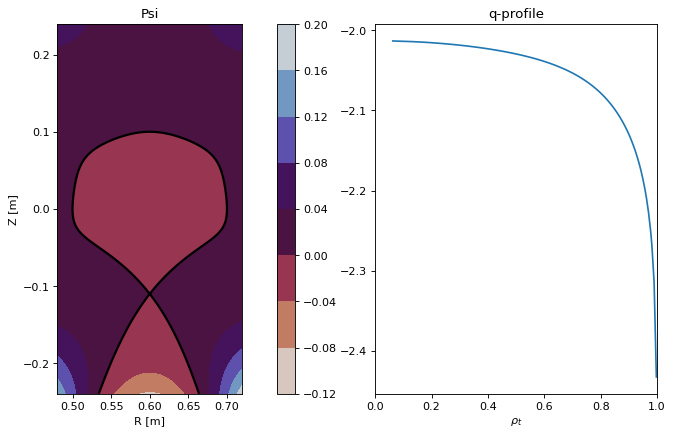

TJ-K/Taylor_circ.json
solovev standardO
triangularity=0.0 elongation=1.0 a/R_0=0.2 

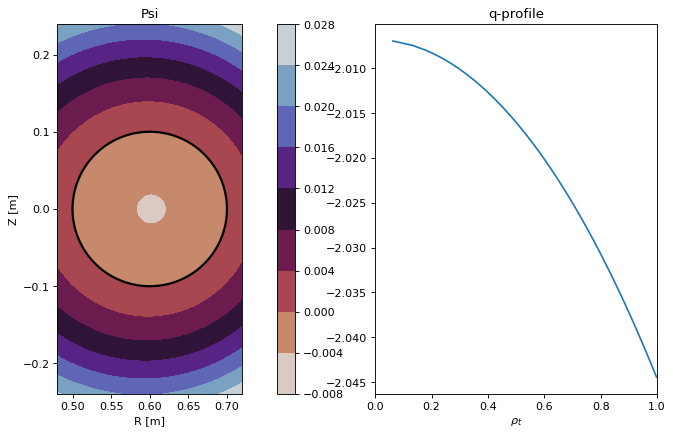

TJ-K/Taylor_elong.json
solovev standardX
triangularity=0.5 elongation=1.8 a/R_0=0.2 

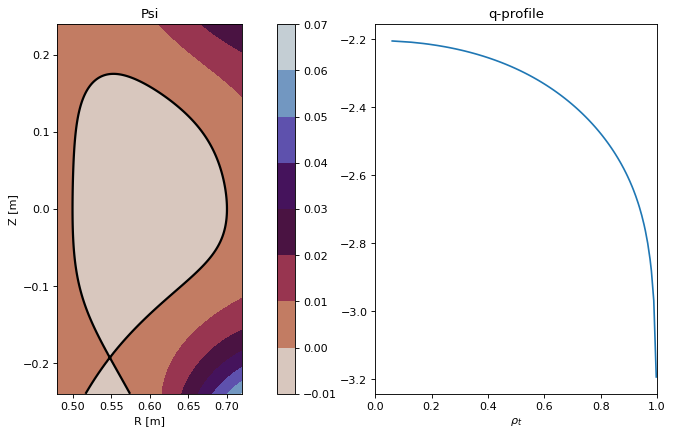

TJ-K/rfp_elong.json
solovev standardX
triangularity=0.5 elongation=1.8 a/R_0=0.2 

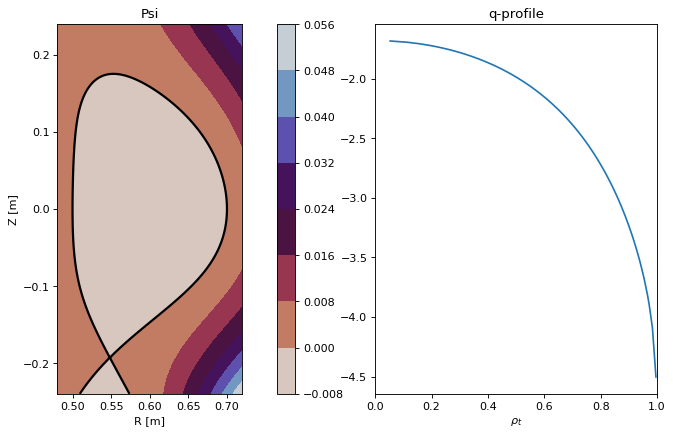

TJ-K/woX_rfp_elong.json
solovev standardO
triangularity=0.5 elongation=1.8 a/R_0=0.2 

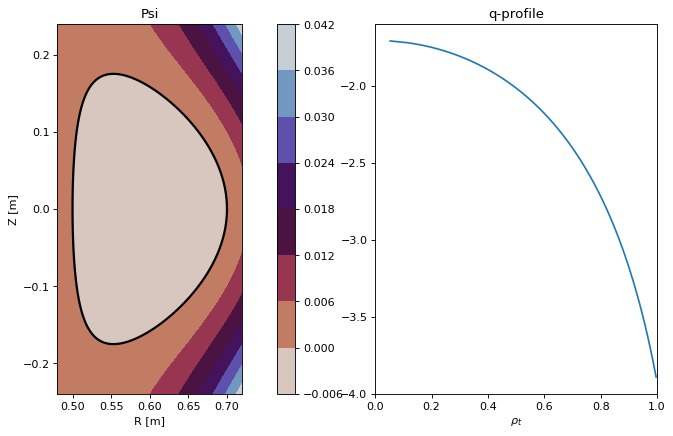

circular.json
circular standardO
triangularity=0 elongation=1 a/R_0=0.3


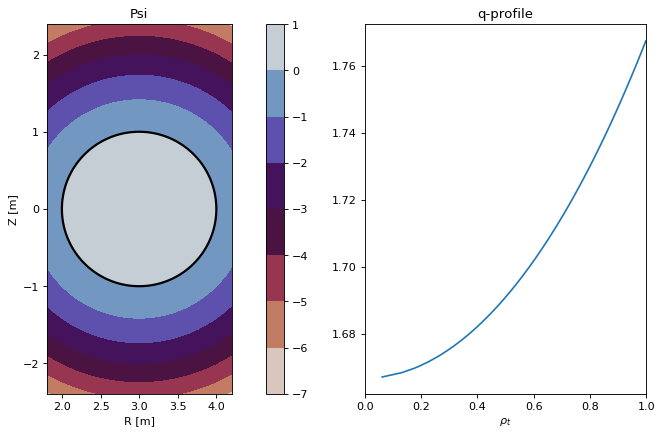

enrx_tcv.json
least squares fit; Matlab geometry file of TCV equilibrium for Enabling research project: X-point
polynomial standardX
triangularity=0.4 elongation=1.5 a/R_0=0.3 

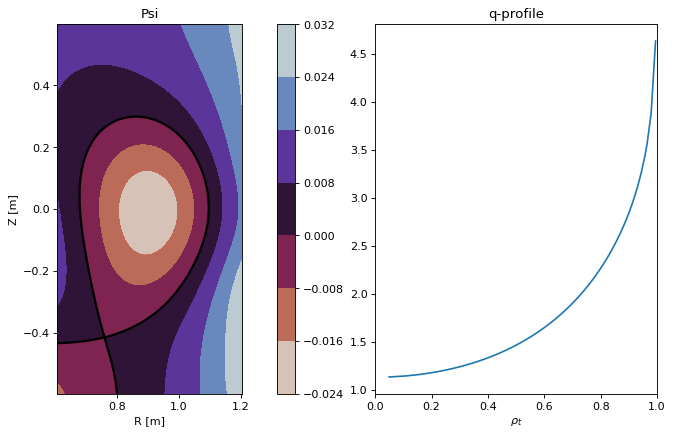

enrx_torpex.json
least squares fit; Matlab geometry file of Torpex equilibrium for Enabling research project: X-point
solovev centeredX
triangularity=0.0 elongation=1.0 a/R_0=0.2 

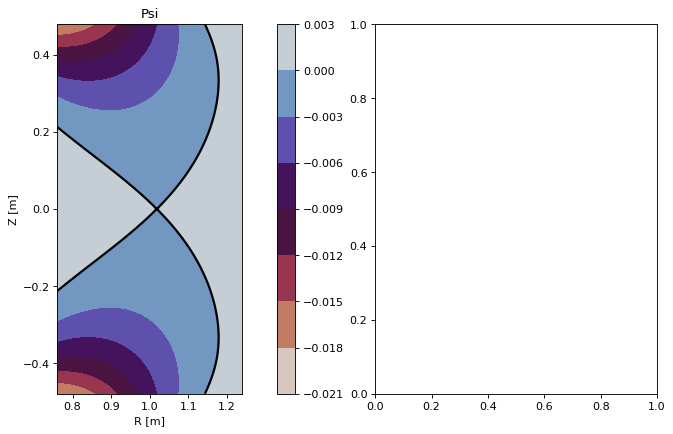

guenter.json
Sine functions; Guenter et al, J. Comput. Phys. 209 (2005) 354
guenter square
triangularity=0 elongation=1 a/R_0=0.3


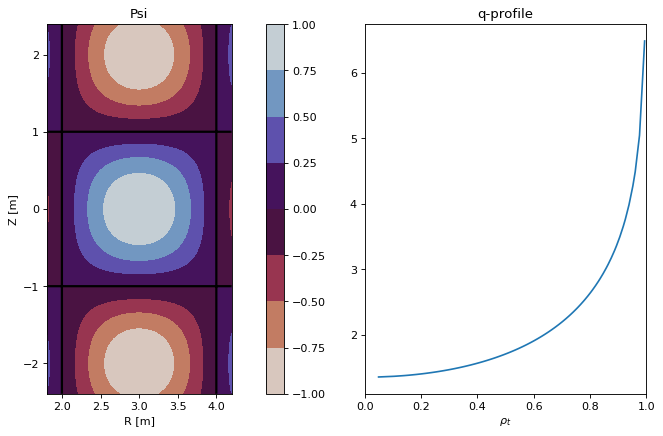

toroidal.json
toroidal none
triangularity=0 elongation=1 a/R_0=0.1


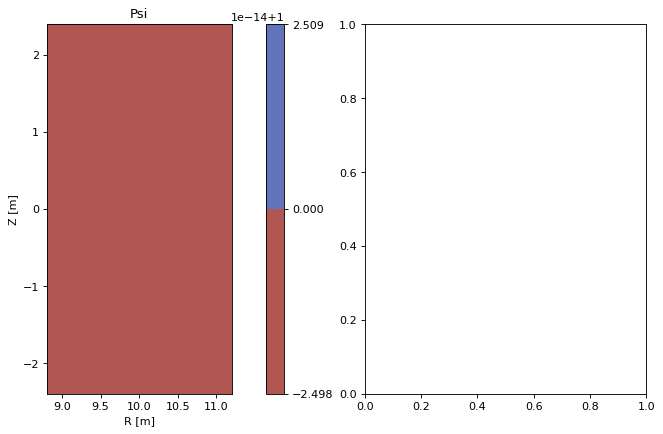

In [7]:
# Now do the same for all geometry files
for f in sorted(mag.files()):
    inputfile["magnetic_field"]["params"] = mag.select(f)
    print(f)
    if "comment" in inputfile["magnetic_field"]["params"]:
        print(inputfile["magnetic_field"]["params"]["comment"])
    rep.run(inputfile)
    plot("temp.nc")

In [8]:
# clean up
rep.clean()